In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import json

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import optuna

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score




In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim,dropout1,dropout2):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1=nn.Dropout(dropout1)
        
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        self.bn2 = nn.BatchNorm1d(input_dim)
        self.dropout2=nn.Dropout(dropout2)

    def forward(self, x):
        residual = x  # 入力を保存 (ショートカット)
        out = torch.relu(self.bn1(self.fc1(x)))
        out=self.dropout1(out)

        out = self.bn2(self.fc2(out))
        out=self.dropout2(out)

        out += residual  # ショートカット接続
        return torch.relu(out)


In [3]:
class ResNetBinaryClassifier(nn.Module):
    def __init__(self, input_dim, num_blocks, hidden_dim, dropout1, dropout2):
        super(ResNetBinaryClassifier, self).__init__()
        self.blocks = nn.Sequential(
            *[ResidualBlock(input_dim, hidden_dim, dropout1, dropout2) for _ in range(num_blocks)]
        )
        self.output_layer = nn.Linear(input_dim, 1)  # 出力層

    def forward(self, x):
        x = self.blocks(x)
        x = torch.sigmoid(self.output_layer(x))  # 2値分類用シグモイド
        return x

In [4]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=0)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [5]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

In [6]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    hidden_dim=trial.suggest_categorical("hidden_dim",[64,128,256])
    num_blocks=trial.suggest_categorical("num_blocks",[3,4,5])
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   

    # モデルの定義
    model = ResNetBinaryClassifier(
        input_dim=X_train_tensor.shape[1],
        num_blocks=num_blocks,
        hidden_dim=hidden_dim,
        dropout1=dropout1,
        dropout2=dropout2
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >=0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaのプルーニング機能
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  


In [7]:
device_id = 1 
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-18 13:40:50,024] A new study created in memory with name: no-name-2f57fa4b-a182-4187-9bca-9c0533542076
/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:40:58,422] Trial 0 finished with value: 0.15200911195659603 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.0, 'dropout2': 0.1, 'learning_rate': 0.00010406562946785872, 'weight_decay': 0.009525114451203374}. Best is trial 0

Early stopping at epoch 44
Final MCC: 0.1520


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:41:01,129] Trial 1 finished with value: 0.20661098348154688 and parameters: {'hidden_dim': 256, 'num_blocks': 4, 'dropout1': 0.45, 'dropout2': 0.05, 'learning_rate': 0.0028566265933467703, 'weight_decay': 0.0024180270104055845}. Best is trial 1 with value: 0.20661098348154688.


Early stopping at epoch 13
Final MCC: 0.2066


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:41:08,314] Trial 2 finished with value: 0.11306592631617944 and parameters: {'hidden_dim': 128, 'num_blocks': 5, 'dropout1': 0.05, 'dropout2': 0.2, 'learning_rate': 0.03498398841228746, 'weight_decay': 3.3181622039531307e-05}. Best is trial 1 with value: 0.20661098348154688.


Early stopping at epoch 30
Final MCC: 0.1131


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:41:12,172] Trial 3 finished with value: 0.17794433285390665 and parameters: {'hidden_dim': 64, 'num_blocks': 5, 'dropout1': 0.30000000000000004, 'dropout2': 0.35000000000000003, 'learning_rate': 0.017951223693436408, 'weight_decay': 6.450437711711392e-05}. Best is trial 1 with value: 0.20661098348154688.


Early stopping at epoch 17
Final MCC: 0.1779


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:41:17,390] Trial 4 finished with value: 0.23490673361625033 and parameters: {'hidden_dim': 256, 'num_blocks': 3, 'dropout1': 0.15000000000000002, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0001968896232914715, 'weight_decay': 0.00010328053276706531}. Best is trial 4 with value: 0.23490673361625033.


Early stopping at epoch 31
Final MCC: 0.2349


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:41:19,875] Trial 5 finished with value: 0.08021904054019983 and parameters: {'hidden_dim': 128, 'num_blocks': 3, 'dropout1': 0.0, 'dropout2': 0.25, 'learning_rate': 0.05161746325716877, 'weight_decay': 0.004956219676226088}. Best is trial 4 with value: 0.23490673361625033.
/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been 

Early stopping at epoch 14
Final MCC: 0.0802


[I 2024-12-18 13:41:27,133] Trial 7 finished with value: 0.2514221960540895 and parameters: {'hidden_dim': 128, 'num_blocks': 4, 'dropout1': 0.0, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00022283026660963005, 'weight_decay': 0.0032733791144535424}. Best is trial 7 with value: 0.2514221960540895.


Early stopping at epoch 37
Final MCC: 0.2514


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:41:27,393] Trial 8 pruned. 
[I 2024-12-18 13:41:27,602] Trial 9 pruned. 
[I 2024-12-18 13:41:33,237] Trial 10 finished with value: 0.1891473010262702 and parameters: {'hidden_dim': 128, 'num_blocks': 4, 'dropout1': 0.2, 'dropout2': 0.5, 'learning_rate': 0.0008572768518353595, 'weight_decay': 0.053026764847304335}. Best is trial 7 with value: 0.251422196

Early stopping at epoch 28
Final MCC: 0.1891


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:41:40,835] Trial 11 finished with value: 0.15822258889610805 and parameters: {'hidden_dim': 256, 'num_blocks': 4, 'dropout1': 0.15000000000000002, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00011132673507279031, 'weight_decay': 0.00036659466931526264}. Best is trial 7 with value: 0.2514221960540895.
/tmp/ipykernel_41978/2074326936.py:7: FutureW

Early stopping at epoch 38
Final MCC: 0.1582


[I 2024-12-18 13:41:41,222] Trial 13 pruned. 
[I 2024-12-18 13:41:41,455] Trial 14 pruned. 
[I 2024-12-18 13:41:47,715] Trial 15 finished with value: 0.13133951751507011 and parameters: {'hidden_dim': 128, 'num_blocks': 4, 'dropout1': 0.25, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00023820915213319124, 'weight_decay': 0.052562435611801205}. Best is trial 7 with value: 0.2514221960540895.


Early stopping at epoch 32
Final MCC: 0.1313


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:41:47,915] Trial 16 pruned. 
[I 2024-12-18 13:41:48,109] Trial 17 pruned. 
[I 2024-12-18 13:42:02,517] Trial 18 finished with value: 0.234863468925647 and parameters: {'hidden_dim': 128, 'num_blocks': 4, 'dropout1': 0.5, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0002018067909494334, 'weight_decay': 0.00016739464642742024}. Best is trial 7 with

Early stopping at epoch 73
Final MCC: 0.2349


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:42:02,770] Trial 19 pruned. 
[I 2024-12-18 13:42:03,003] Trial 20 pruned. 
[I 2024-12-18 13:42:18,969] Trial 21 finished with value: 0.2589743696347 and parameters: {'hidden_dim': 128, 'num_blocks': 4, 'dropout1': 0.5, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00020074197084020835, 'weight_decay': 0.0001773175649472692}. Best is trial 21 with 

Early stopping at epoch 80
Final MCC: 0.2590


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:42:24,038] Trial 22 finished with value: 0.12274500057241113 and parameters: {'hidden_dim': 128, 'num_blocks': 4, 'dropout1': 0.25, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0004847271394670682, 'weight_decay': 6.794918115881088e-05}. Best is trial 21 with value: 0.2589743696347.


Early stopping at epoch 25
Final MCC: 0.1227


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:42:24,252] Trial 23 pruned. 
[I 2024-12-18 13:42:39,014] Trial 24 finished with value: 0.2388292215065641 and parameters: {'hidden_dim': 128, 'num_blocks': 4, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'learning_rate': 0.00010337789177054491, 'weight_decay': 3.113128186183179e-05}. Best is trial 21 with value: 0.2589743696347.


Early stopping at epoch 74
Final MCC: 0.2388


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:42:51,332] Trial 25 finished with value: 0.15467524598371948 and parameters: {'hidden_dim': 128, 'num_blocks': 4, 'dropout1': 0.4, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0001024335842872085, 'weight_decay': 2.87178224698494e-05}. Best is trial 21 with value: 0.2589743696347.


Early stopping at epoch 64
Final MCC: 0.1547


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:42:51,539] Trial 26 pruned. 
[I 2024-12-18 13:43:01,643] Trial 27 finished with value: 0.2283332846729748 and parameters: {'hidden_dim': 128, 'num_blocks': 4, 'dropout1': 0.45, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0003473439264790239, 'weight_decay': 0.0002601159312360521}. Best is trial 21 with value: 0.2589743696347.


Early stopping at epoch 55
Final MCC: 0.2283


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:43:18,486] Trial 28 finished with value: 0.22316474223212845 and parameters: {'hidden_dim': 128, 'num_blocks': 4, 'dropout1': 0.30000000000000004, 'dropout2': 0.25, 'learning_rate': 0.0001642842472862106, 'weight_decay': 0.0012930798466561902}. Best is trial 21 with value: 0.2589743696347.


Early stopping at epoch 81
Final MCC: 0.2232


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:43:38,624] Trial 29 finished with value: 0.2586502677259226 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.45, 'dropout2': 0.1, 'learning_rate': 0.00012117091189140579, 'weight_decay': 0.01391298944636411}. Best is trial 21 with value: 0.2589743696347.


Final MCC: 0.2587


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:43:38,878] Trial 30 pruned. 
[I 2024-12-18 13:43:57,376] Trial 31 finished with value: 0.25697387074879735 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 0.00011978796316969473, 'weight_decay': 0.016864625165397842}. Best is trial 21 with value: 0.2589743696347.


Early stopping at epoch 91
Final MCC: 0.2570


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:44:10,499] Trial 32 finished with value: 0.25252551273902735 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.5, 'dropout2': 0.05, 'learning_rate': 0.00013647780894571077, 'weight_decay': 0.014092795307174118}. Best is trial 21 with value: 0.2589743696347.


Early stopping at epoch 74
Final MCC: 0.2525


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:44:31,084] Trial 33 finished with value: 0.22352986386836018 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.5, 'dropout2': 0.05, 'learning_rate': 0.00013791444779723432, 'weight_decay': 0.020070823208964837}. Best is trial 21 with value: 0.2589743696347.


Final MCC: 0.2235


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:44:31,349] Trial 34 pruned. 
[I 2024-12-18 13:44:36,748] Trial 35 finished with value: 0.19716195257041821 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.5, 'dropout2': 0.05, 'learning_rate': 0.0005557984427425381, 'weight_decay': 0.012299829339881142}. Best is trial 21 with value: 0.2589743696347.


Early stopping at epoch 25
Final MCC: 0.1972


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:44:37,003] Trial 36 pruned. 
[I 2024-12-18 13:45:02,296] Trial 37 finished with value: 0.16139498195772142 and parameters: {'hidden_dim': 64, 'num_blocks': 5, 'dropout1': 0.45, 'dropout2': 0.05, 'learning_rate': 0.00014029681554651526, 'weight_decay': 0.015227858928296667}. Best is trial 21 with value: 0.2589743696347.


Final MCC: 0.1614


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:45:17,755] Trial 38 finished with value: 0.21602245579047738 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 0.0001494891101830328, 'weight_decay': 0.005276599129776173}. Best is trial 21 with value: 0.2589743696347.


Early stopping at epoch 69
Final MCC: 0.2160


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:45:17,962] Trial 39 pruned. 
[I 2024-12-18 13:45:30,818] Trial 40 finished with value: 0.19739794575271097 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.45, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00033190041173242744, 'weight_decay': 0.0020176894745784217}. Best is trial 21 with value: 0.2589743696347.


Early stopping at epoch 60
Final MCC: 0.1974


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:45:38,858] Trial 41 finished with value: 0.17130404326634582 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.35000000000000003, 'dropout2': 0.05, 'learning_rate': 0.00024499636762345987, 'weight_decay': 0.03493831533367838}. Best is trial 21 with value: 0.2589743696347.


Early stopping at epoch 35
Final MCC: 0.1713


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:46:00,995] Trial 42 finished with value: 0.21267143241840136 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 0.00016553592152458203, 'weight_decay': 0.0030092098248503136}. Best is trial 21 with value: 0.2589743696347.


Early stopping at epoch 97
Final MCC: 0.2127


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:46:23,337] Trial 43 finished with value: 0.3161935009291388 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.45, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00010133130072109258, 'weight_decay': 0.009709314253093087}. Best is trial 43 with value: 0.3161935009291388.


Final MCC: 0.3162


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:46:44,816] Trial 44 finished with value: 0.2589743696347 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.45, 'dropout2': 0.0, 'learning_rate': 0.00010980264589668926, 'weight_decay': 0.006286184002889496}. Best is trial 43 with value: 0.3161935009291388.


Final MCC: 0.2590


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:47:08,829] Trial 45 finished with value: 0.23806625464787998 and parameters: {'hidden_dim': 64, 'num_blocks': 5, 'dropout1': 0.35000000000000003, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00010244300624123383, 'weight_decay': 0.007350554800918719}. Best is trial 43 with value: 0.3161935009291388.


Final MCC: 0.2381


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:47:09,113] Trial 46 pruned. 
[I 2024-12-18 13:47:28,017] Trial 47 finished with value: 0.2876894065388417 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.4, 'dropout2': 0.25, 'learning_rate': 0.00027428638183242684, 'weight_decay': 0.001944699695577028}. Best is trial 43 with value: 0.3161935009291388.


Early stopping at epoch 85
Final MCC: 0.2877


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:47:39,539] Trial 48 finished with value: 0.21733559127470506 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0002977691753699783, 'weight_decay': 0.0021632578449211027}. Best is trial 43 with value: 0.3161935009291388.


Early stopping at epoch 71
Final MCC: 0.2173


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:47:52,216] Trial 49 finished with value: 0.3127296926049439 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.45, 'dropout2': 0.45, 'learning_rate': 0.00041729887546416885, 'weight_decay': 0.006783583230805202}. Best is trial 43 with value: 0.3161935009291388.
/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has be

Early stopping at epoch 62
Final MCC: 0.3127


[I 2024-12-18 13:47:52,503] Trial 51 pruned. 
[I 2024-12-18 13:48:08,454] Trial 52 finished with value: 0.2749328942581873 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.45, 'dropout2': 0.4, 'learning_rate': 0.00022143311045563633, 'weight_decay': 0.008881724952096012}. Best is trial 43 with value: 0.3161935009291388.


Early stopping at epoch 82
Final MCC: 0.2749


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:48:16,786] Trial 53 finished with value: 0.17933841191876132 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.4, 'dropout2': 0.4, 'learning_rate': 0.0007623908135837928, 'weight_decay': 0.0069389433807035585}. Best is trial 43 with value: 0.3161935009291388.
/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has bee

Early stopping at epoch 42
Final MCC: 0.1793


[I 2024-12-18 13:48:17,217] Trial 55 pruned. 
[I 2024-12-18 13:48:38,373] Trial 56 finished with value: 0.3185691354916671 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.4, 'dropout2': 0.5, 'learning_rate': 0.00019818345059160225, 'weight_decay': 0.010024765726594232}. Best is trial 56 with value: 0.3185691354916671.


Final MCC: 0.3186


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:48:38,608] Trial 57 pruned. 
[I 2024-12-18 13:48:38,828] Trial 58 pruned. 
[I 2024-12-18 13:48:39,053] Trial 59 pruned. 
[I 2024-12-18 13:48:39,281] Trial 60 pruned. 
[I 2024-12-18 13:48:59,892] Trial 61 finished with value: 0.2524251922578796 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.45, 'dropout2': 0.35000000000000003, 'learnin

Final MCC: 0.2524


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:49:00,111] Trial 62 pruned. 
[I 2024-12-18 13:49:17,200] Trial 63 finished with value: 0.2686920389979384 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.45, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00016157722899046162, 'weight_decay': 0.004432833992952705}. Best is trial 56 with value: 0.3185691354916671.


Early stopping at epoch 81
Final MCC: 0.2687


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:49:25,409] Trial 64 finished with value: 0.30445732398352765 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0001771160020623963, 'weight_decay': 0.003758976673069562}. Best is trial 56 with value: 0.3185691354916671.


Early stopping at epoch 56
Final MCC: 0.3045


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:49:36,814] Trial 65 finished with value: 0.16910940367045932 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.35000000000000003, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00028076842797554094, 'weight_decay': 0.003908021895969904}. Best is trial 56 with value: 0.3185691354916671.


Early stopping at epoch 56
Final MCC: 0.1691


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:49:37,026] Trial 66 pruned. 
[I 2024-12-18 13:49:56,432] Trial 67 finished with value: 0.2553725207868155 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00015754895362711396, 'weight_decay': 0.0027196456071615998}. Best is trial 56 with value: 0.3185691354916671.


Final MCC: 0.2554


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:49:56,637] Trial 68 pruned. 
[I 2024-12-18 13:50:08,166] Trial 69 finished with value: 0.2013878178804103 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.30000000000000004, 'dropout2': 0.25, 'learning_rate': 0.0002165809389330048, 'weight_decay': 0.010868781319531343}. Best is trial 56 with value: 0.3185691354916671.


Early stopping at epoch 54
Final MCC: 0.2014


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:50:24,339] Trial 70 finished with value: 0.2602692878478548 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00013682658418072408, 'weight_decay': 0.004936325272757559}. Best is trial 56 with value: 0.3185691354916671.


Early stopping at epoch 78
Final MCC: 0.2603


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:50:24,569] Trial 71 pruned. 
[I 2024-12-18 13:50:45,547] Trial 72 finished with value: 0.19955196667096528 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.45, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00016826019287865358, 'weight_decay': 0.007808436696369511}. Best is trial 56 with value: 0.3185691354916671.


Final MCC: 0.1996


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:50:45,790] Trial 73 pruned. 
[I 2024-12-18 13:50:46,061] Trial 74 pruned. 
[I 2024-12-18 13:51:02,925] Trial 75 finished with value: 0.21733559127470506 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.45, 'dropout2': 0.5, 'learning_rate': 0.00012459933305781012, 'weight_decay': 0.00544816949778743}. Best is trial 56 with value: 0.31856

Early stopping at epoch 90
Final MCC: 0.2173


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:51:03,153] Trial 76 pruned. 
[I 2024-12-18 13:51:03,431] Trial 77 pruned. 
[I 2024-12-18 13:51:21,831] Trial 78 finished with value: 0.30382551338376107 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.45, 'dropout2': 0.4, 'learning_rate': 0.00014492278411519223, 'weight_decay': 0.008434039240498915}. Best is trial 56 with value: 0.3185

Final MCC: 0.3038


[I 2024-12-18 13:51:22,103] Trial 80 pruned. 
[I 2024-12-18 13:51:22,292] Trial 81 pruned. 
[I 2024-12-18 13:51:42,012] Trial 82 finished with value: 0.2627818048829654 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.45, 'dropout2': 0.4, 'learning_rate': 0.00016888857569234518, 'weight_decay': 0.0031552415065064883}. Best is trial 56 with value: 0.3185691354916671.


Early stopping at epoch 99
Final MCC: 0.2628


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:51:42,232] Trial 83 pruned. 
[I 2024-12-18 13:51:57,168] Trial 84 finished with value: 0.2028633304070839 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.45, 'dropout2': 0.4, 'learning_rate': 0.00021905997492492716, 'weight_decay': 0.003429622377449146}. Best is trial 56 with value: 0.3185691354916671.
/tmp/ipykernel_41978/2074326936.p

Early stopping at epoch 76
Final MCC: 0.2029


[I 2024-12-18 13:51:57,483] Trial 86 pruned. 
[I 2024-12-18 13:52:14,213] Trial 87 finished with value: 0.24364103448269775 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.45, 'dropout2': 0.45, 'learning_rate': 0.00011646575119408315, 'weight_decay': 0.008380656662470008}. Best is trial 56 with value: 0.3185691354916671.


Final MCC: 0.2436


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:52:14,425] Trial 88 pruned. 
[I 2024-12-18 13:52:34,480] Trial 89 finished with value: 0.15200911195659603 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.4, 'dropout2': 0.2, 'learning_rate': 0.00016393583628894397, 'weight_decay': 0.004368436900895962}. Best is trial 56 with value: 0.3185691354916671.


Early stopping at epoch 98
Final MCC: 0.1520


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:52:46,119] Trial 90 finished with value: 0.20455491857885993 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.2, 'dropout2': 0.4, 'learning_rate': 0.00020423984276565497, 'weight_decay': 0.002936904044049939}. Best is trial 56 with value: 0.3185691354916671.


Early stopping at epoch 59
Final MCC: 0.2046


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:53:07,439] Trial 91 finished with value: 0.3162890911135341 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00012712210180921142, 'weight_decay': 0.0053441754115826565}. Best is trial 56 with value: 0.3185691354916671.


Final MCC: 0.3163


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:53:25,390] Trial 92 finished with value: 0.16663993361171764 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.45, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00011714721296293974, 'weight_decay': 0.0056131903508928015}. Best is trial 56 with value: 0.3185691354916671.


Final MCC: 0.1666


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:53:43,647] Trial 93 finished with value: 0.19953329281440324 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00015603296517326625, 'weight_decay': 0.0015471563330442173}. Best is trial 56 with value: 0.3185691354916671.


Early stopping at epoch 91
Final MCC: 0.1995


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:53:43,879] Trial 94 pruned. 
[I 2024-12-18 13:54:02,923] Trial 95 finished with value: 0.3127296926049439 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00012544254526681962, 'weight_decay': 0.00847538646825946}. Best is trial 56 with value: 0.3185691354916671.


Final MCC: 0.3127


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:54:15,818] Trial 96 finished with value: 0.220748811927002 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.05, 'dropout2': 0.35000000000000003, 'learning_rate': 0.0001287354111471168, 'weight_decay': 0.013346877735101114}. Best is trial 56 with value: 0.3185691354916671.


Early stopping at epoch 69
Final MCC: 0.2207


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:54:16,100] Trial 97 pruned. 
[I 2024-12-18 13:54:24,591] Trial 98 finished with value: 0.24460788119839852 and parameters: {'hidden_dim': 256, 'num_blocks': 3, 'dropout1': 0.35000000000000003, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0001006831055214432, 'weight_decay': 0.010641869983982538}. Best is trial 56 with value: 0.3185691354916671.


Early stopping at epoch 50
Final MCC: 0.2446


/tmp/ipykernel_41978/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41978/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:54:36,929] Trial 99 finished with value: 0.29466976898542185 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'learning_rate': 0.0002030897000419717, 'weight_decay': 0.022126120621443972}. Best is trial 56 with value: 0.3185691354916671.


Early stopping at epoch 63
Final MCC: 0.2947
Best Parameters:  {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.4, 'dropout2': 0.5, 'learning_rate': 0.00019818345059160225, 'weight_decay': 0.010024765726594232}
Best Validation F1:  0.3185691354916671


In [8]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_ResNet_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


Epoch [1/150], Loss: 0.9249
Epoch [1/150], Train Loss: 0.9249, Val Loss: 0.7816
Epoch [2/150], Loss: 0.8548
Epoch [2/150], Train Loss: 0.8548, Val Loss: 0.7499
Epoch [3/150], Loss: 0.8224
Epoch [3/150], Train Loss: 0.8224, Val Loss: 0.7131
Epoch [4/150], Loss: 0.7638
Epoch [4/150], Train Loss: 0.7638, Val Loss: 0.6916
Epoch [5/150], Loss: 0.7435
Epoch [5/150], Train Loss: 0.7435, Val Loss: 0.6699
Epoch [6/150], Loss: 0.7241
Epoch [6/150], Train Loss: 0.7241, Val Loss: 0.6545
Epoch [7/150], Loss: 0.7076
Epoch [7/150], Train Loss: 0.7076, Val Loss: 0.6389
Epoch [8/150], Loss: 0.6903
Epoch [8/150], Train Loss: 0.6903, Val Loss: 0.6321
Epoch [9/150], Loss: 0.6978
Epoch [9/150], Train Loss: 0.6978, Val Loss: 0.6246
Epoch [10/150], Loss: 0.6849
Epoch [10/150], Train Loss: 0.6849, Val Loss: 0.6171
Epoch [11/150], Loss: 0.6647
Epoch [11/150], Train Loss: 0.6647, Val Loss: 0.6116
Epoch [12/150], Loss: 0.6785
Epoch [12/150], Train Loss: 0.6785, Val Loss: 0.6113
Epoch [13/150], Loss: 0.6676
Epoch

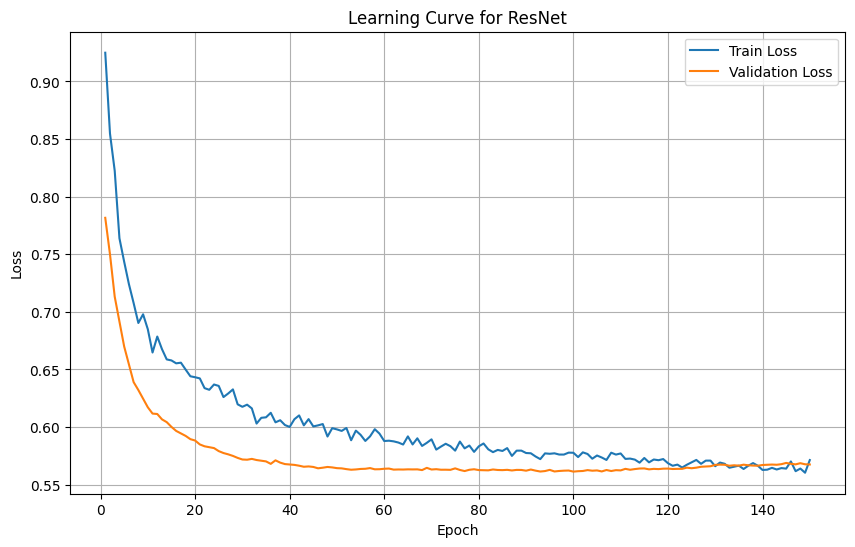

In [15]:
best_params=study.best_params
model = ResNetBinaryClassifier(input_dim=X_train_tensor.shape[1],num_blocks=best_params["num_blocks"],hidden_dim=best_params["hidden_dim"],dropout1=best_params["dropout1"],dropout2=best_params["dropout2"]).to(device)

# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=150
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for ResNet')
plt.legend()
plt.grid()
plt.show()

Accuracy: 62.30%
Precision: 0.4947
Recall: 0.5657
F1 Score: 0.5278
Matthews Correlation Coefficient: 0.2178
Specificity: 0.6570


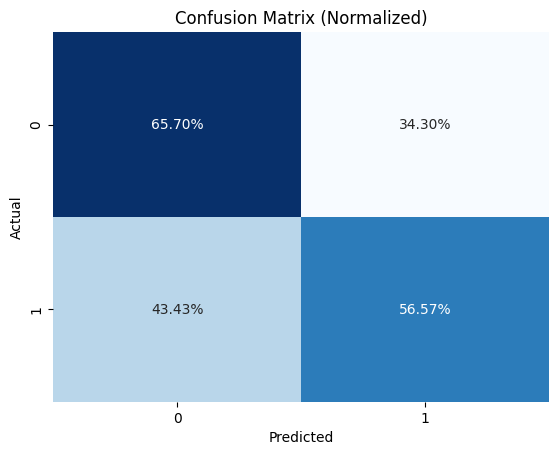

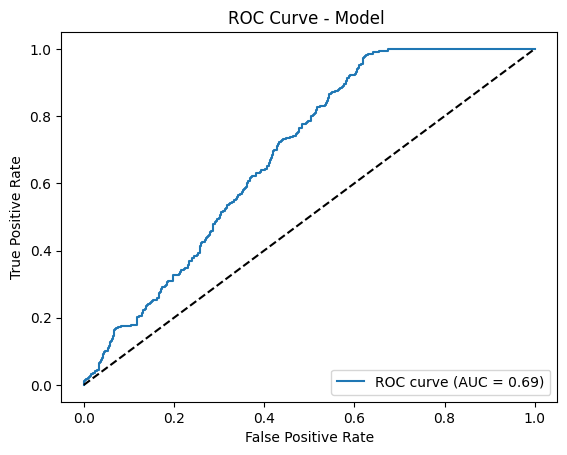

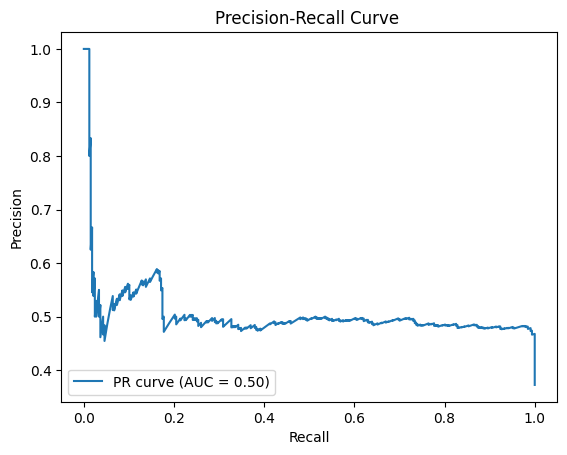

In [16]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >=0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [17]:
torch.save(model.state_dict(), 'model_params/ResNet.pth')



In [12]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,920
       BatchNorm1d-2                   [-1, 64]             128
           Dropout-3                   [-1, 64]               0
            Linear-4                   [-1, 29]           1,885
       BatchNorm1d-5                   [-1, 29]              58
           Dropout-6                   [-1, 29]               0
     ResidualBlock-7                   [-1, 29]               0
            Linear-8                   [-1, 64]           1,920
       BatchNorm1d-9                   [-1, 64]             128
          Dropout-10                   [-1, 64]               0
           Linear-11                   [-1, 29]           1,885
      BatchNorm1d-12                   [-1, 29]              58
          Dropout-13                   [-1, 29]               0
    ResidualBlock-14                   